In [1]:
# Import from standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import time
import random

# Import functions from file
from algorithms import *
from functions import *

# Pokemon Dataset

Data Processing

In [2]:
# Import data
df = pd.read_csv('data/dataset_pokemon.csv')
df.head(3)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [3]:
# Select features
X = df.iloc[:,4:11] #Data features
legend = df.iloc[:,12] #data labels (legendary = True)
y = [1 if leg else -1 for leg in legend] # Create label vector
N = X.shape[0] #Number of observations

X.head(10)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,318,45,49,49,65,65,45
1,405,60,62,63,80,80,60
2,525,80,82,83,100,100,80
3,625,80,100,123,122,120,80
4,309,39,52,43,60,50,65
5,405,58,64,58,80,65,80
6,534,78,84,78,109,85,100
7,634,78,130,111,130,85,100
8,634,78,104,78,159,115,100
9,314,44,48,65,50,64,43


In [4]:
# Standardize data
for col in X.columns:
    X[col] = (X[col] - X[col].mean())/X[col].std()

In [5]:
# Split maintaining proportions of response variable
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X,y, test_size=0.5, stratify=y)
X_labeled = np.array(X_labeled)
X_unlabeled = np.array(X_unlabeled)
y_labeled = np.array(y_labeled).reshape(-1,1)
y_unlabeled = np.array(y_unlabeled).reshape(-1,1)
known_variables = X_labeled.shape[0]

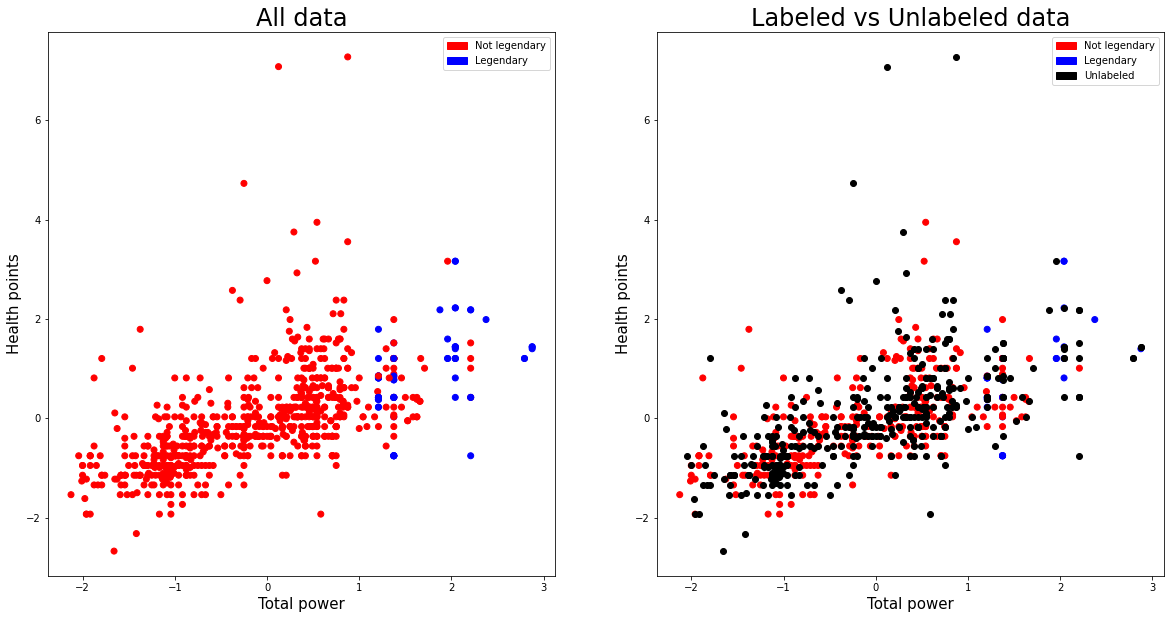

In [6]:
# Data visualization
data = {'x1 labeled': X_labeled[:,0], 'x2 labeled': X_labeled[:,1],
        'x1 unlabeled': X_unlabeled[:,0], 'x2 unlabeled': X_unlabeled[:,1],
        'y labeled': y_labeled, 'y unlabeled': y_unlabeled}
label = {'x1': 'Total power', 'x2': 'Health points', 'class': ('Not legendary','Legendary')}
plot_data(data, label)

In [7]:
# Computing weight matrix
W = distance_matrix(X_labeled,X_unlabeled, order = 1)
W = 1/(W**2+1) #Converting the distance matrix into a similarity (weight) matrix with values in [0,1]
W = normalize_weight_matrix(W,y_labeled,2)

Gradient Descent

In [8]:
#Method Parameters
alpha = 1e-5
maxIter = 5000

In [9]:
# Optimize with 'Gradient descent'
(y,y_list_GD,time_list_GD) = gradient_descent(W,y_labeled,np.zeros([N-known_variables,1]),armijo=False, alpha=alpha, maxIter=maxIter)

In [10]:
cost_list_GD = [cost_function(y_unlabeled, y_labeled, W) for y_unlabeled in y_list_GD]

BCGD Random

In [11]:
#Method Parameters
block_length = 1
alpha = 1e-5
n_block = int(W.shape[0]/block_length)
maxIter = maxIter*n_block

In [12]:
# Optimize with 'BCGD randomized'
(y,y_list_random,time_list_BCGD_random) = bcgd_randomized(W,y_labeled,np.zeros([N-known_variables,1]), alpha=alpha, maxIter=maxIter, block_length=block_length)

In [13]:
time_list_BCGD_random = [t for idx, t in enumerate(time_list_BCGD_random) if (idx % n_block) == 0]
y_list_random = [y for idx, y in enumerate(y_list_random) if (idx % n_block) == 0]
cost_list_BCGD_random = [cost_function(y_unlabeled, y_labeled, W) for y_unlabeled in y_list_random]

BCGD Cyclic

In [14]:
#Method Parameters
block_length = 1
alpha = 1e-5
maxIter = 5000

In [15]:
# Optimize with 'BCGD cyclic'
(y,y_list_cyclic,time_list_BCGD_cyclic) = bcgd_cyclic(W,y_labeled,np.zeros([N-known_variables,1]), alpha=alpha, maxIter=maxIter, block_length=block_length)

In [16]:
cost_list_BCGD_cyclic = [cost_function(y_unlabeled, y_labeled, W) for y_unlabeled in y_list_cyclic]

Algorithm and Model Performance

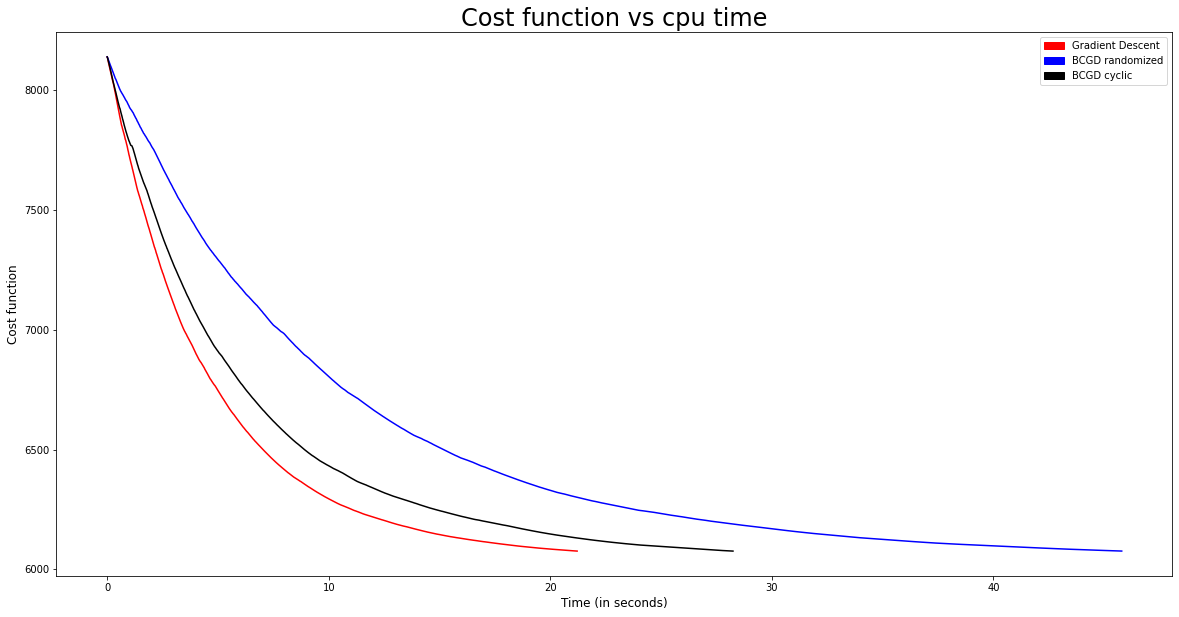

In [17]:
# Plot loss vs CPU time
time_list = [time_list_GD, time_list_BCGD_random, time_list_BCGD_cyclic]
loss_list = [cost_list_GD, cost_list_BCGD_random, cost_list_BCGD_cyclic]
plot_loss(time_list, loss_list)

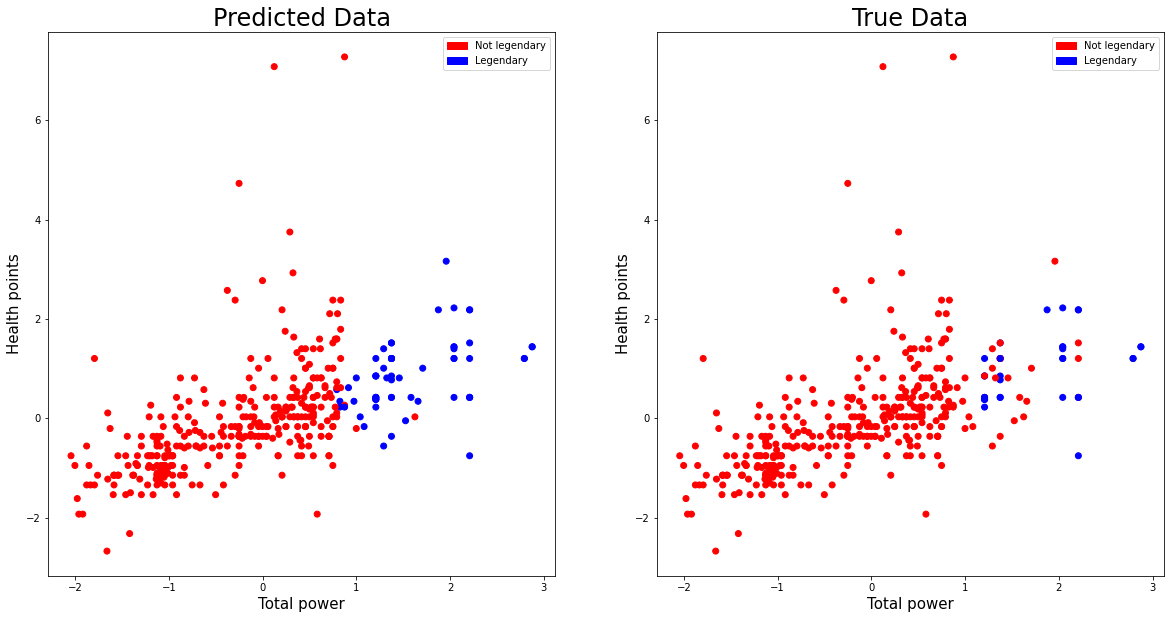

In [18]:
# Qualitative evaluation of the best model performance
y_best = np.sign(y_list_GD[-1])
plot_performace(y_best, label, data, "Predicted Data")

Text(50.99999999999999, 0.5, 'True label')

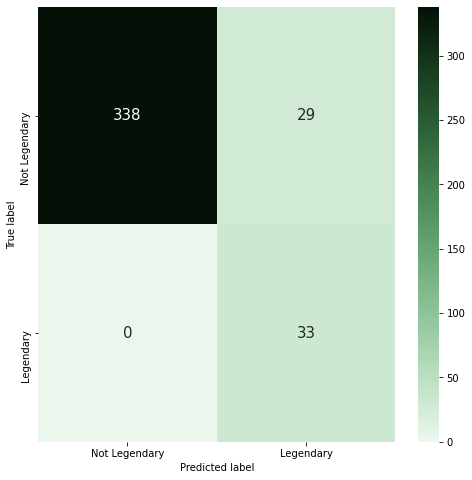

In [21]:
sizeplots = (8,8)
plt.figure(figsize=sizeplots)

cm = confusion_matrix(y_unlabeled, y_best)

sns.heatmap(cm,
            fmt= ".5g",
            annot=True,
            annot_kws={"size": 15},
            cmap = sns.cubehelix_palette(start=2, rot=0, dark=0.05, light=.95, reverse=False, as_cmap=True),
            xticklabels=['Not Legendary', 'Legendary'],
            yticklabels=['Not Legendary', 'Legendary'])
plt.xlabel("Predicted label")
plt.ylabel("True label")

In [20]:
pr,rc,f1,su = precision_recall_fscore_support(y_unlabeled,y_best ,average='binary')
    
print("""
----------------------------------------------------
-Precision: {}
-Recall: {}
-F1 score: {}
----------------------------------------------------""".format(pr,rc,f1))


----------------------------------------------------
-Precision: 0.532258064516129
-Recall: 1.0
-F1 score: 0.6947368421052631
----------------------------------------------------
